In [54]:
import os
 
import matplotlib.pyplot as plt
 
import torchvision.datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable
 


In [55]:
def train(model, device, train_set_loader, optimizer, epoch, logging_interval=100):
    model.train()
    for batch_idx, (data, target) in enumerate(train_set_loader):
        data, y = data.to(device), target.to(device)
        optimizer.zero_grad()
        ycap = model(data)
        loss = F.nll_loss(ycap, y)
        loss.backward()
        optimizer.step()
 
        if batch_idx % logging_interval == 0:
            pred = ycap.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct = pred.eq(y.view_as(pred)).float().mean().item()
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f} Accuracy: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_set_loader.dataset),
                100. * batch_idx / len(train_set_loader), loss.item(),
                100. * correct))

In [56]:
def epoch_train(model):
    epoch = 1
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)
 
    epoch = 2
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
    train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)
 
    epoch = 3
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)

In [57]:
def test(model, device, test_set_loader):
    model.eval()
    test_loss = 0
    correct = 0
 
    with torch.no_grad():
        for data, target in test_set_loader:
            data, target = data.to(device), target.to(device)
            ycap = model(data)
            test_loss += F.nll_loss(ycap, target, reduce=True).item()
            pred = ycap.max(1, keepdim=True)[1] 
            correct += pred.eq(target.view_as(pred)).sum().item()
 
    test_loss /= len(test_set_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(test_loss,correct, len(test_set_loader.dataset),
                                                                               100. * correct / len(test_set_loader.dataset)))

In [58]:
def download_mnist(data_path):
    if not os.path.exists(data_path):
        os.mkdir(data_path)
    transformation = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
    training_set = torchvision.datasets.MNIST(
        data_path, train=True, transform=transformation, download=True)
    testing_set = torchvision.datasets.MNIST(
        data_path, train=False, transform=transformation, download=True)
    return training_set, testing_set

In [59]:
batch_size = 1000
DATA_PATH = './data'
training_set, testing_set = download_mnist(DATA_PATH)
train_set_loader = torch.utils.data.DataLoader(
    dataset=training_set,
    batch_size=batch_size,
    shuffle=True)
test_set_loader = torch.utils.data.DataLoader(
    dataset=testing_set,
    batch_size=batch_size,
    shuffle=False)


In [60]:
# Faced issue with gpu (cuda) hence using cpu only
device = torch.device("cpu")


In [61]:
class SpikingNeuronLayer(nn.Module):
 
    def __init__(
        self, device, n_inputs=28*28, n_hidden=100, 
        decay_multiplier=0.9, threshold=2.0, penalty_threshold=2.5
    ):
        super(SpikingNeuronLayer, self).__init__()
        self.device = device
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.decay_multiplier = decay_multiplier
        self.threshold = threshold
        self.penalty_threshold = penalty_threshold
 
        self.fc = nn.Linear(n_inputs, n_hidden)
 
        self.init_parameters()
        self.reset_state()
        self.to(self.device)
 
    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
 
    def reset_state(self):
        self.prev_inner = torch.zeros([self.n_hidden]).to(self.device)
        self.prev_outer = torch.zeros([self.n_hidden]).to(self.device)
 
    def forward(self, x):
          if self.prev_inner.dim() == 1:
            batch_size = x.shape[0]
            self.prev_inner = torch.stack(batch_size * [self.prev_inner])
            self.prev_outer = torch.stack(batch_size * [self.prev_outer])
 
          input_excitation = self.fc(x)
  
          inner_excitation = input_excitation + self.prev_inner * self.decay_multiplier
  
          outer_excitation = F.relu(inner_excitation - self.threshold)
  
          do_penalize_gate = (outer_excitation > 0).float()
          inner_excitation = inner_excitation - do_penalize_gate * (
              self.penalty_threshold/self.threshold * inner_excitation)
  
          outer_excitation = outer_excitation 
          delayed_return_state = self.prev_inner
          delayed_return_output = self.prev_outer
          self.prev_inner = inner_excitation
          self.prev_outer = outer_excitation
          return delayed_return_state, delayed_return_output


In [62]:
class InputDataToSpikingPerceptronLayer(nn.Module):
 
    def __init__(self, device):
        super(InputDataToSpikingPerceptronLayer, self).__init__()
        self.device = device
 
        self.reset_state()
        self.to(self.device)
 
    def reset_state(self):
        pass
 
    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)
        random_activation_perceptron = torch.rand(x.shape).to(self.device)
        return random_activation_perceptron * x

In [63]:
class OutputDataToSpikingPerceptronLayer(nn.Module):
 
    def __init__(self, average_output=True):
        super(OutputDataToSpikingPerceptronLayer, self).__init__()
        if average_output:
            self.reducer = lambda x, dim: x.sum(dim=dim)
        else:
            self.reducer = lambda x, dim: x.mean(dim=dim)
 
    def forward(self, x):
        if type(x) == list:
            x = torch.stack(x)
        return self.reducer(x, 0)

In [64]:

class SpikingNet(nn.Module):
    def __init__(self, device, n_time_steps, begin_eval):
        super(SpikingNet, self).__init__()
        assert (0 <= begin_eval and begin_eval < n_time_steps)
        self.device = device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval
 
        self.input_conversion = InputDataToSpikingPerceptronLayer(device)
 
        self.layer1 = SpikingNeuronLayer(
            device, n_inputs=28*28, n_hidden=100,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
 
        self.layer2 = SpikingNeuronLayer(
            device, n_inputs=100, n_hidden=10,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
 
        self.output_conversion = OutputDataToSpikingPerceptronLayer(
            average_output=False)  # Sum on outputs.
 
        self.to(self.device)
 
    def forward_through_time(self, x):
        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()
 
        out = []
 
        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)
            layer1_state, layer1_output = self.layer1(xi)
            layer2_state, layer2_output = self.layer2(layer1_output)
 
            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            out.append(layer2_state)
 
        out = self.output_conversion(out[self.begin_eval:])
        return out, [[all_layer1_states, all_layer1_outputs], [
            all_layer2_states, all_layer2_outputs]]
 
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)
 
    def visualize_all_neurons(self, x):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)
 
        for i, (all_layer_states, all_layer_outputs) in enumerate(layers_state):
            layer_state  =  torch.stack(all_layer_states).data.cpu(
                ).numpy().squeeze().transpose()
            layer_output = torch.stack(all_layer_outputs).data.cpu(
                ).numpy().squeeze().transpose()
 
            self.plot_layer(layer_state, title="Inner state values of neurons for layer {}".format(i))
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i))
 
    def visualize_neuron(self, x, layer_idx, neuron_idx):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)
 
        all_layer_states, all_layer_outputs = layers_state[layer_idx]
        layer_state  =  torch.stack(all_layer_states).data.cpu(
            ).numpy().squeeze().transpose()
        layer_output = torch.stack(all_layer_outputs).data.cpu(
            ).numpy().squeeze().transpose()
 
        self.plot_neuron(
            layer_state[neuron_idx], 
            title="Inner state values neuron {} of layer {}".format(neuron_idx, layer_idx))
        self.plot_neuron(
            layer_output[neuron_idx], 
            title="Output spikes (activation) values of neuron {} of layer {}".format(neuron_idx, layer_idx))
 
    def plot_layer(self, layer_values, title):
        
        width = max(16, layer_values.shape[0] / 8)
        height = max(4, layer_values.shape[1] / 8)
        plt.figure(figsize=(width, height))
        plt.imshow(
            layer_values,
            interpolation="nearest",
            cmap=plt.cm.rainbow
        )
        plt.title(title)
        plt.colorbar()
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")
        plt.show()
 
    def plot_neuron(self, neuron_through_time, title):
        width = max(16, len(neuron_through_time) / 8)
        height = 4
        plt.figure(figsize=(width, height))
        plt.title(title)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")
        plt.show()


In [65]:
class NonSpikingNet(nn.Module):
 
    def __init__(self):
        super(NonSpikingNet, self).__init__()
        self.layer1 = nn.Linear(28*28, 100)
        self.layer2 = nn.Linear(100, 10)
 
    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        x = F.relu(self.layer1(x))
        x =        self.layer2(x)
        return F.log_softmax(x, dim=-1)

Training a Spiking Neural Network

In [66]:
spiking_model = SpikingNet(device, n_time_steps=128, begin_eval=0)
epoch_train(spiking_model)


Train Epoch: 1 [0/60000 (0%)] Loss: 2.379200 Accuracy: 11.10%
Train Epoch: 1 [10000/60000 (17%)] Loss: 1.824720 Accuracy: 19.60%
Train Epoch: 1 [20000/60000 (33%)] Loss: 0.949130 Accuracy: 69.20%
Train Epoch: 1 [30000/60000 (50%)] Loss: 0.537427 Accuracy: 83.20%
Train Epoch: 1 [40000/60000 (67%)] Loss: 0.475639 Accuracy: 84.90%
Train Epoch: 1 [50000/60000 (83%)] Loss: 0.500902 Accuracy: 84.20%


/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0004, Accuracy: 8974/10000 (89.74%)
Train Epoch: 2 [0/60000 (0%)] Loss: 0.390820 Accuracy: 88.40%
Train Epoch: 2 [10000/60000 (17%)] Loss: 0.365816 Accuracy: 89.50%
Train Epoch: 2 [20000/60000 (33%)] Loss: 0.338446 Accuracy: 89.10%
Train Epoch: 2 [30000/60000 (50%)] Loss: 0.338652 Accuracy: 90.80%
Train Epoch: 2 [40000/60000 (67%)] Loss: 0.350924 Accuracy: 89.90%
Train Epoch: 2 [50000/60000 (83%)] Loss: 0.341236 Accuracy: 89.80%

Test set: Average loss: 0.0003, Accuracy: 9064/10000 (90.64%)
Train Epoch: 3 [0/60000 (0%)] Loss: 0.378241 Accuracy: 89.00%
Train Epoch: 3 [10000/60000 (17%)] Loss: 0.305037 Accuracy: 91.70%
Train Epoch: 3 [20000/60000 (33%)] Loss: 0.331278 Accuracy: 89.10%
Train Epoch: 3 [30000/60000 (50%)] Loss: 0.329514 Accuracy: 90.60%
Train Epoch: 3 [40000/60000 (67%)] Loss: 0.324109 Accuracy: 89.10%
Train Epoch: 3 [50000/60000 (83%)] Loss: 0.327831 Accuracy: 90.00%

Test set: Average loss: 0.0003, Accuracy: 9105/10000 (91.05%)


Training a Feedforward Neural Network just for comparison

In [67]:
non_spiking_model = NonSpikingNet().to(device)
epoch_train(non_spiking_model)


Train Epoch: 1 [0/60000 (0%)] Loss: 2.309243 Accuracy: 6.90%
Train Epoch: 1 [10000/60000 (17%)] Loss: 1.875010 Accuracy: 63.10%
Train Epoch: 1 [20000/60000 (33%)] Loss: 1.242811 Accuracy: 77.90%
Train Epoch: 1 [30000/60000 (50%)] Loss: 0.867620 Accuracy: 81.60%
Train Epoch: 1 [40000/60000 (67%)] Loss: 0.672298 Accuracy: 85.50%
Train Epoch: 1 [50000/60000 (83%)] Loss: 0.580445 Accuracy: 85.70%

Test set: Average loss: 0.0005, Accuracy: 8721/10000 (87.21%)
Train Epoch: 2 [0/60000 (0%)] Loss: 0.514506 Accuracy: 86.00%
Train Epoch: 2 [10000/60000 (17%)] Loss: 0.486443 Accuracy: 86.40%
Train Epoch: 2 [20000/60000 (33%)] Loss: 0.492568 Accuracy: 87.10%
Train Epoch: 2 [30000/60000 (50%)] Loss: 0.442013 Accuracy: 89.00%
Train Epoch: 2 [40000/60000 (67%)] Loss: 0.447641 Accuracy: 88.10%
Train Epoch: 2 [50000/60000 (83%)] Loss: 0.449103 Accuracy: 88.70%

Test set: Average loss: 0.0004, Accuracy: 8916/10000 (89.16%)
Train Epoch: 3 [0/60000 (0%)] Loss: 0.392094 Accuracy: 90.00%
Train Epoch: 3 [100

To check how the Neurons spiked

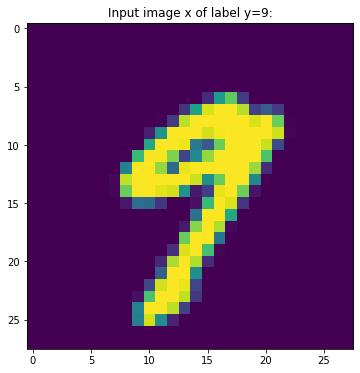

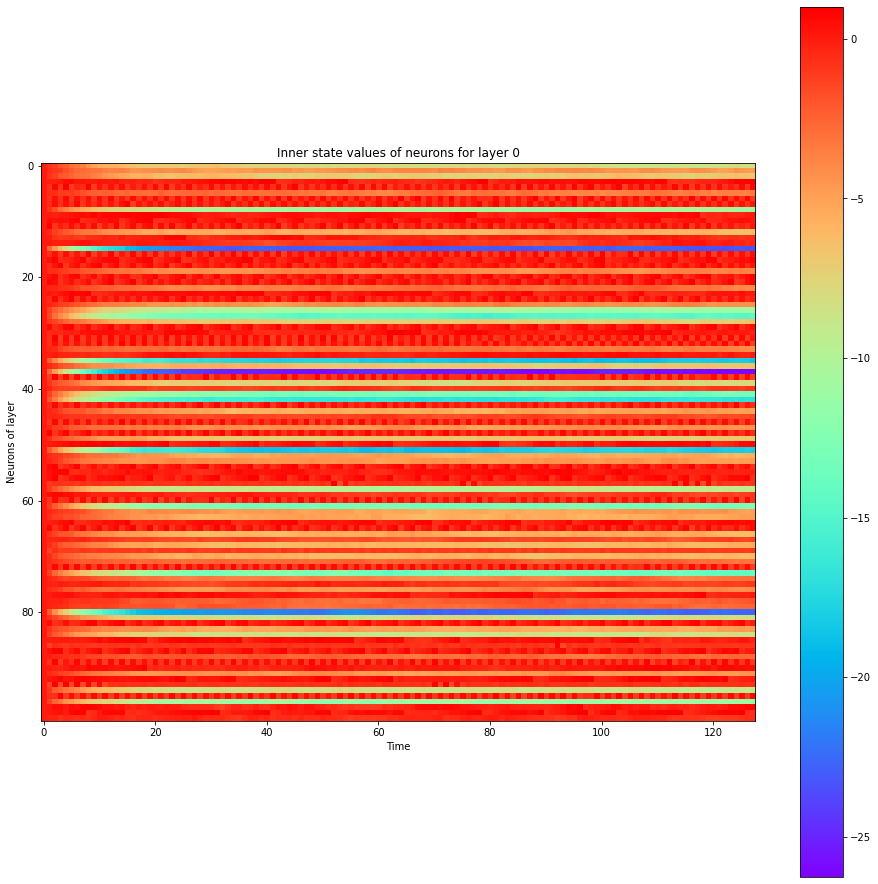

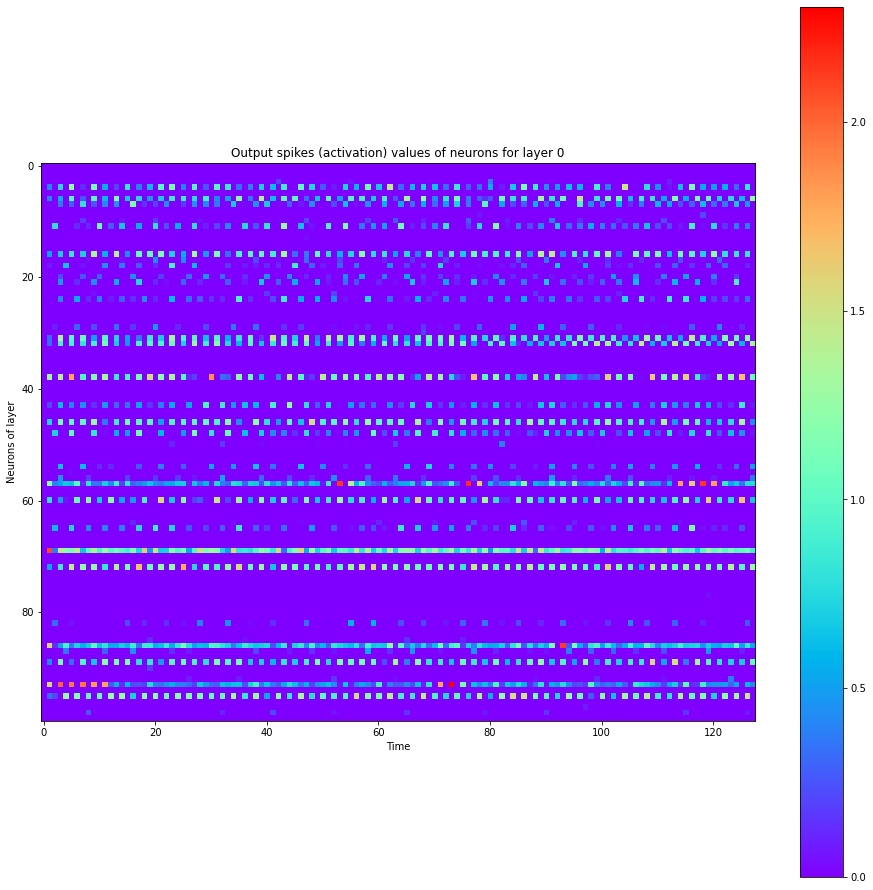

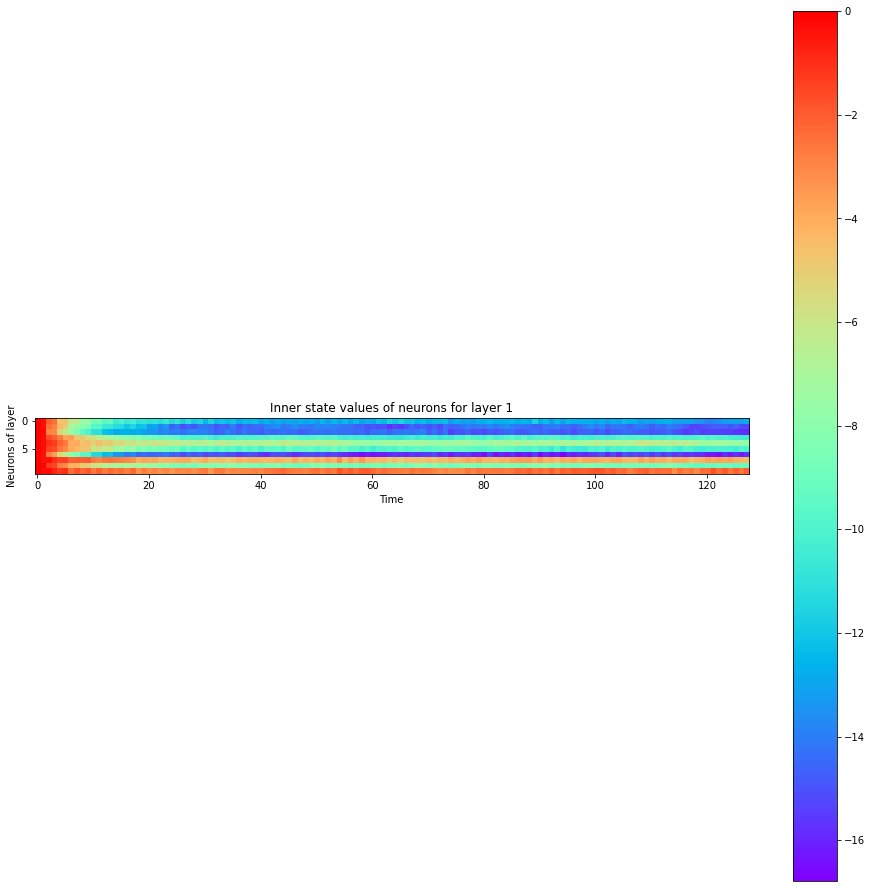

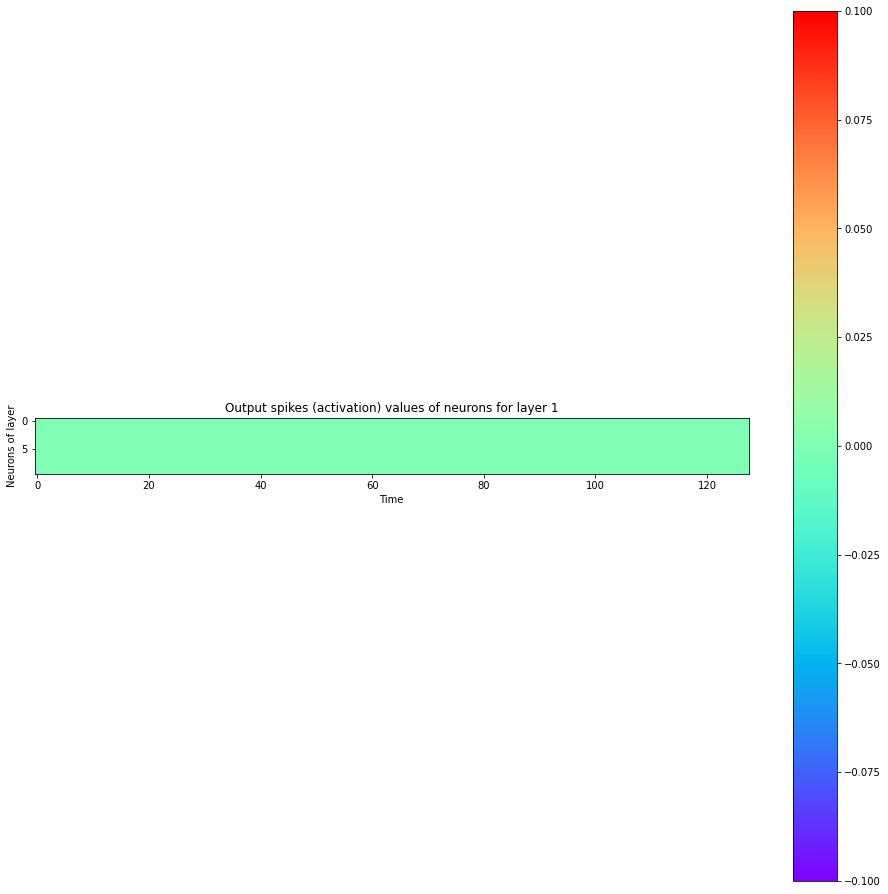

A hidden neuron that looks excited:


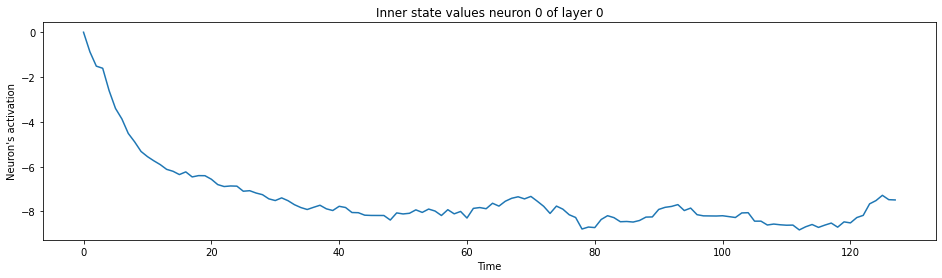

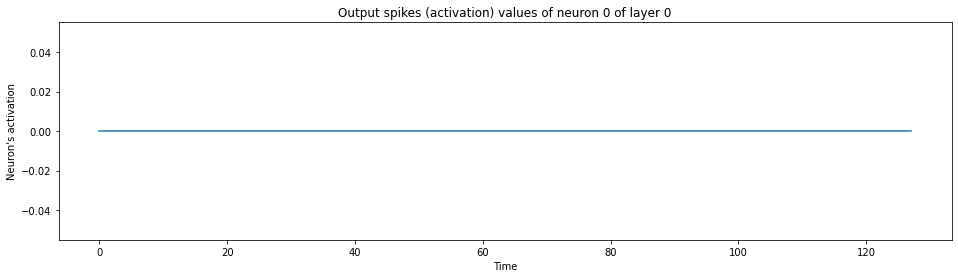

The output neuron of the label:


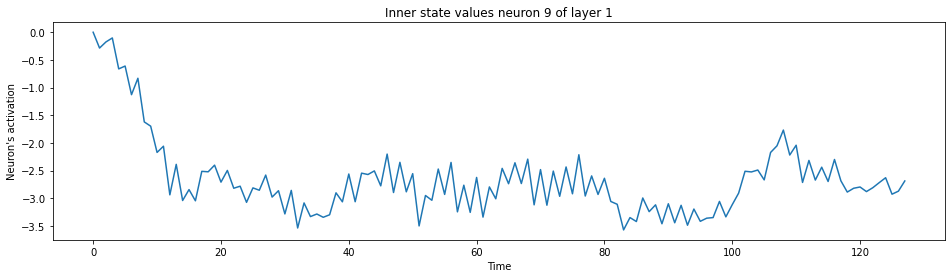

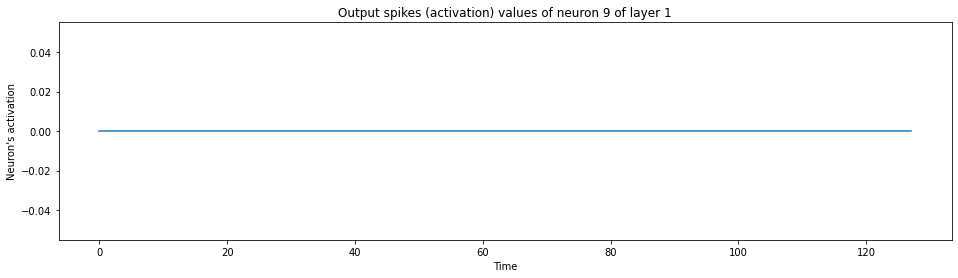

In [71]:
data, target = test_set_loader.__iter__().__next__()
 
# taking 1st testing example:
x = torch.stack([data[20]])
y = target.data.numpy()[20]
plt.figure(figsize=(6,6))
plt.imshow(x.data.cpu().numpy()[0,0])
plt.title("Input image x of label y={}:".format(y))
plt.show()
 
# plotting neuron's activations:
spiking_model.visualize_all_neurons(x)
print("A hidden neuron that looks excited:")
spiking_model.visualize_neuron(x, layer_idx=0, neuron_idx=0)
print("The output neuron of the label:")
spiking_model.visualize_neuron(x, layer_idx=1, neuron_idx=y)


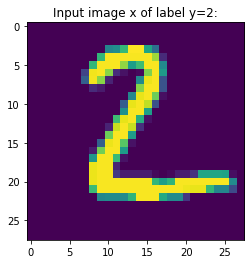

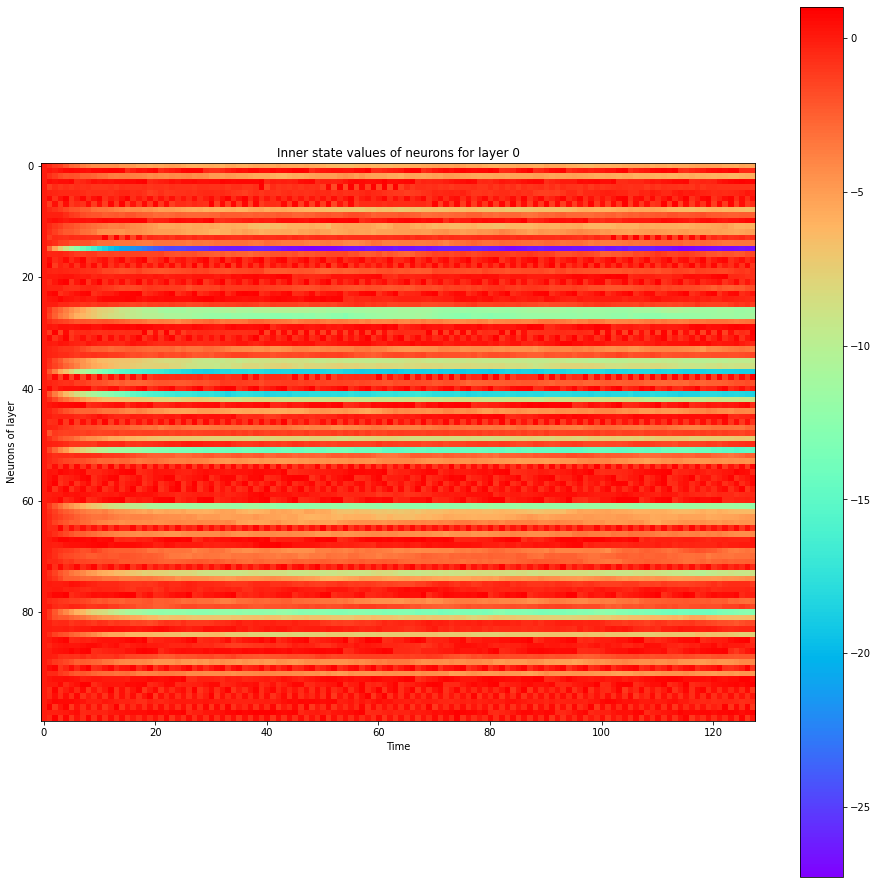

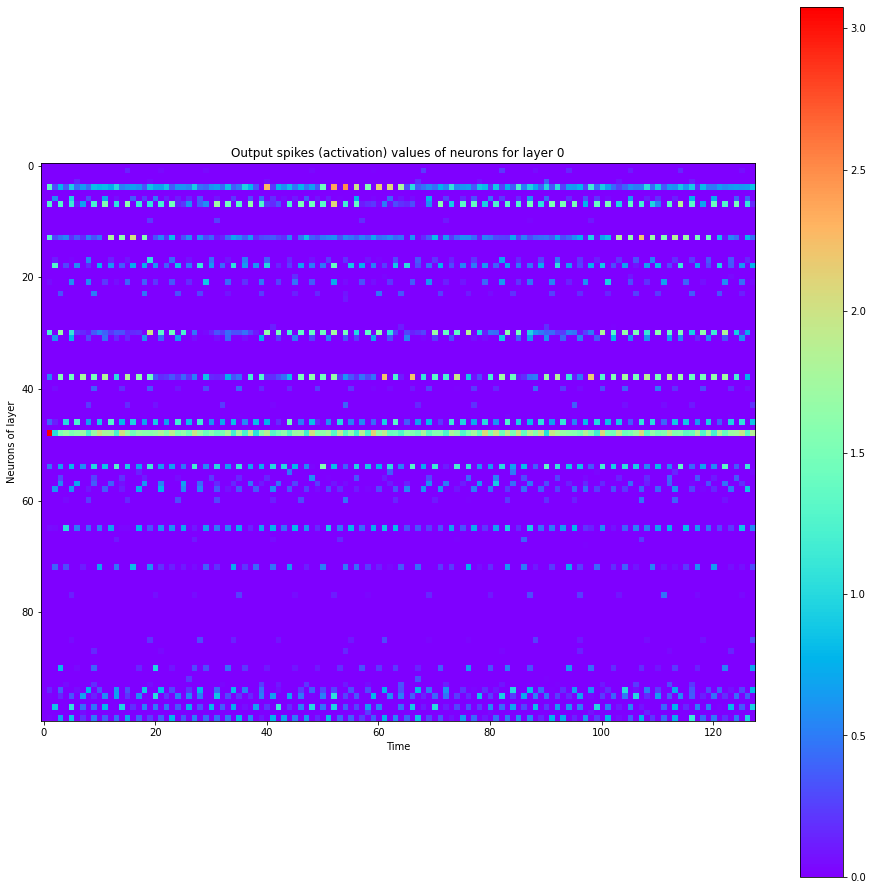

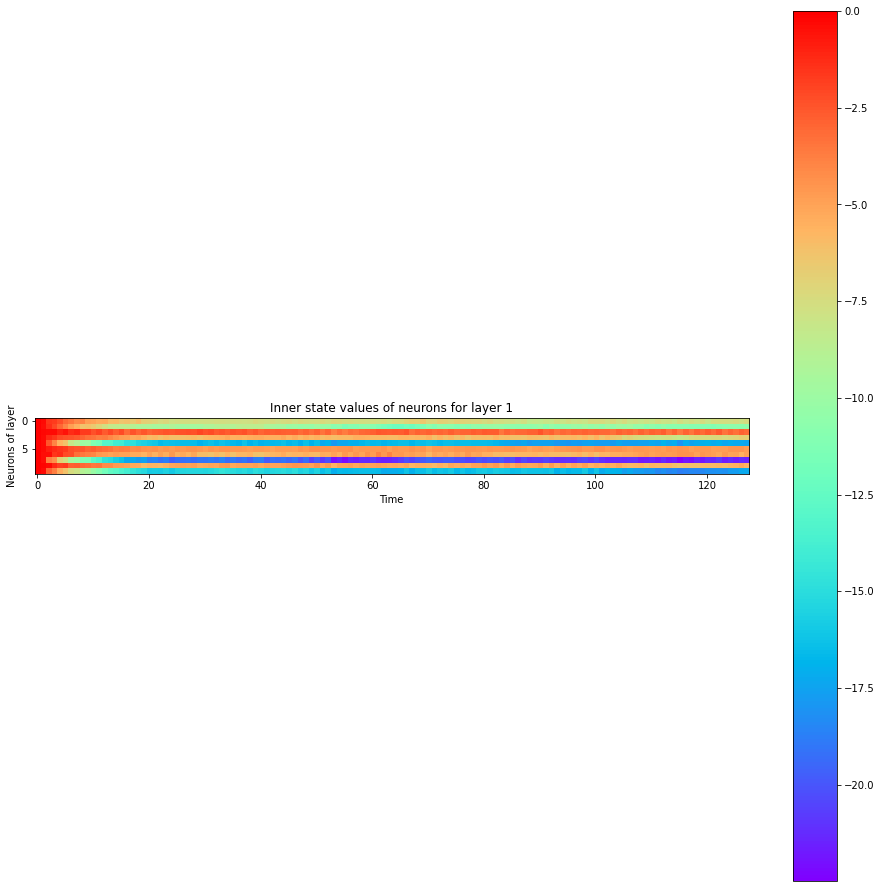

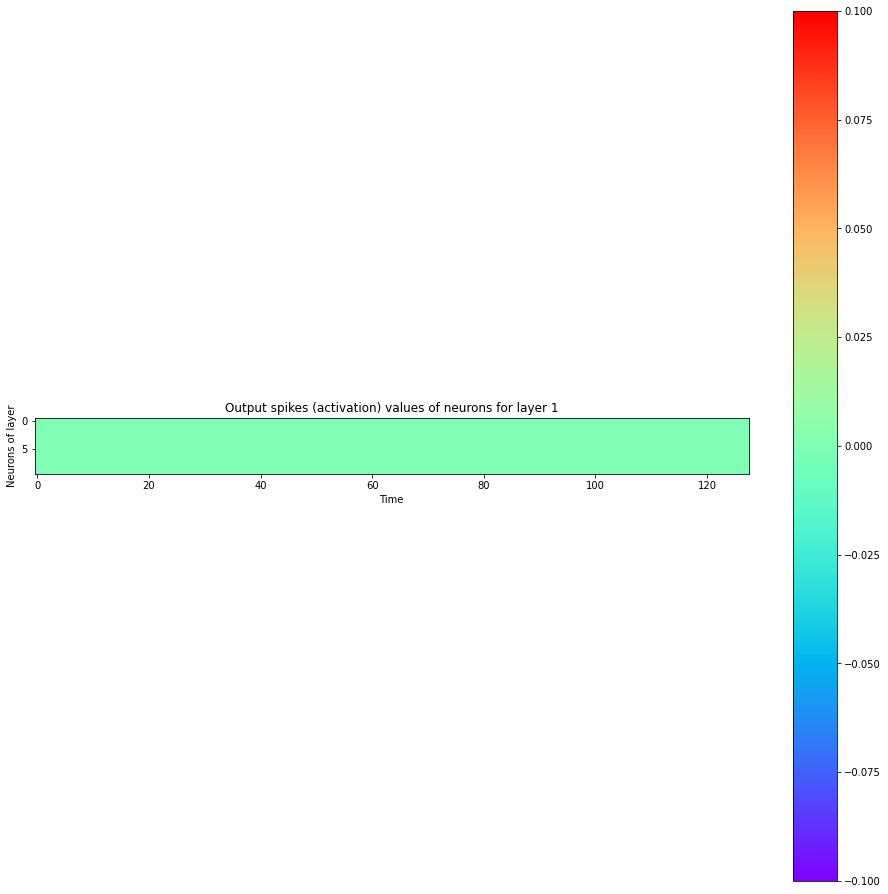

A hidden neuron that looks excited:


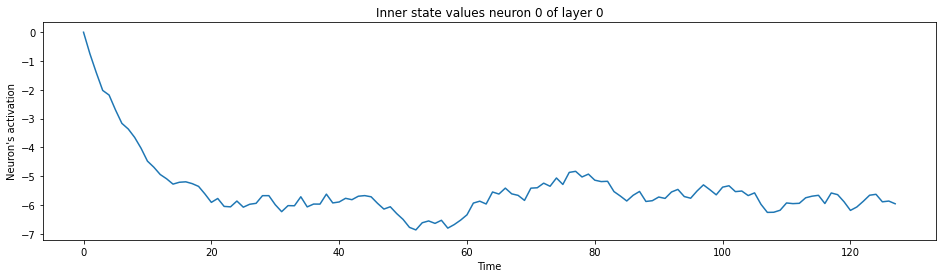

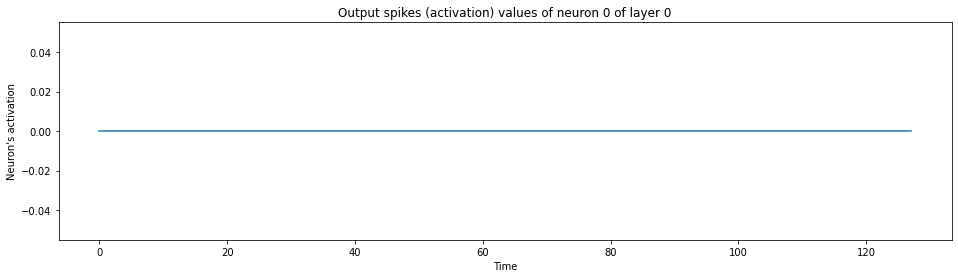

The output neuron of the label:


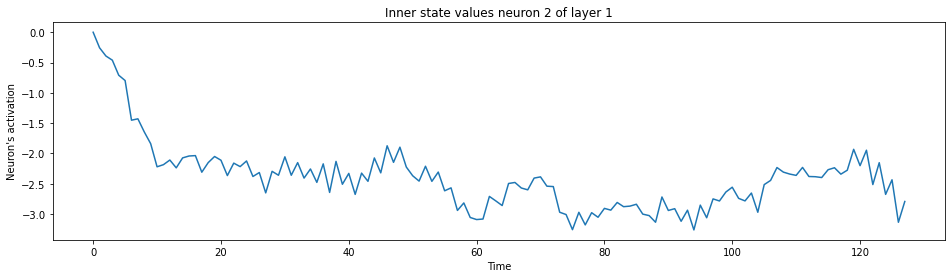

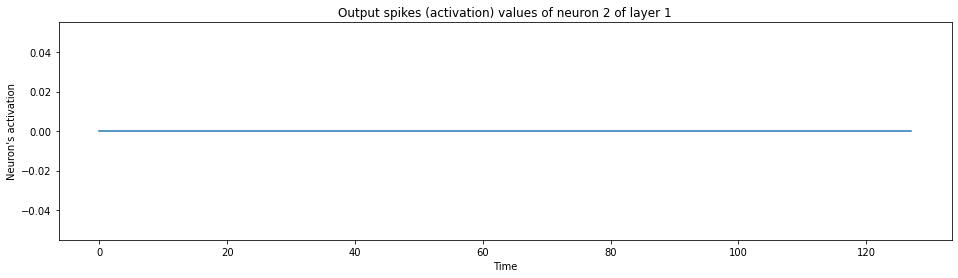

In [69]:
data, target = test_set_loader.__iter__().__next__()
 
# taking 1st testing example:
x = torch.stack([data[1]])
y = target.data.numpy()[1]
plt.figure(figsize=(4,4))
plt.imshow(x.data.cpu().numpy()[0,0])
plt.title("Input image x of label y={}:".format(y))
plt.show()
 
# plotting neuron's activations:
spiking_model.visualize_all_neurons(x)
print("A hidden neuron that looks excited:")
spiking_model.visualize_neuron(x, layer_idx=0, neuron_idx=0)
print("The output neuron of the label:")
spiking_model.visualize_neuron(x, layer_idx=1, neuron_idx=y)


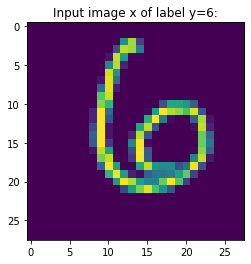

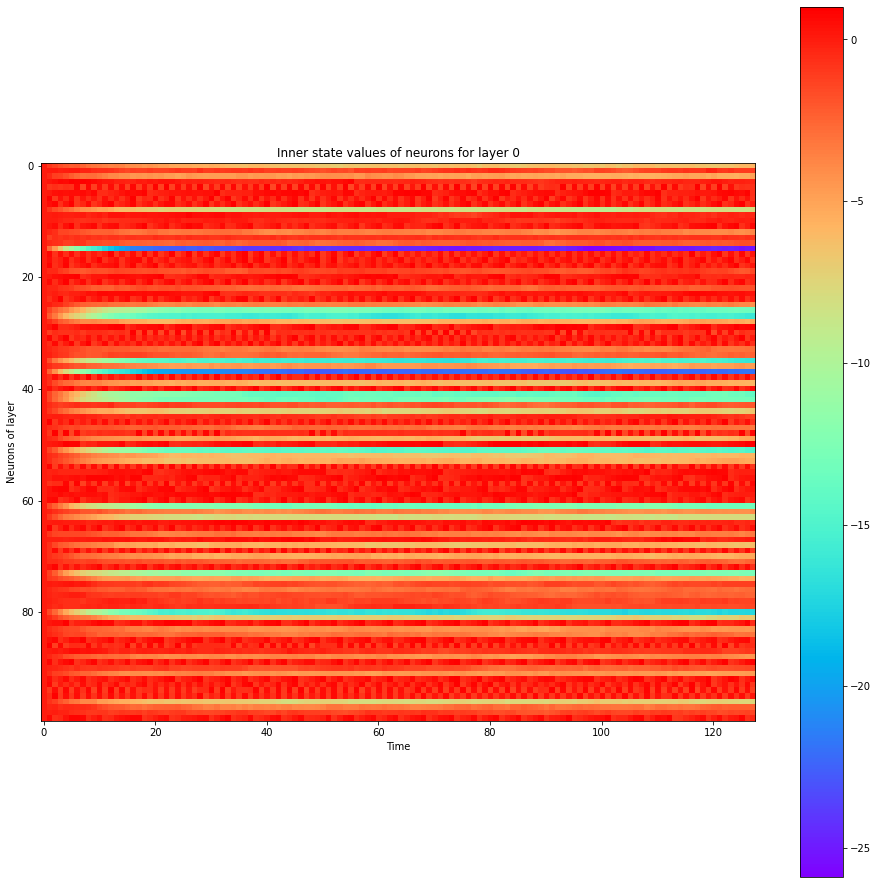

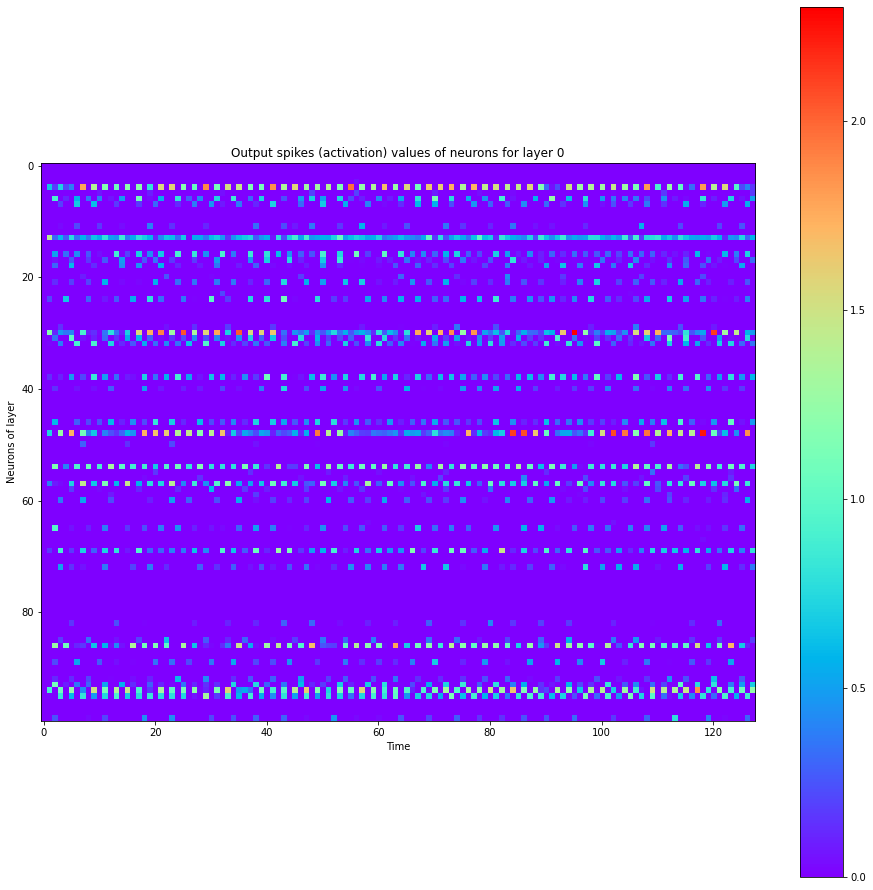

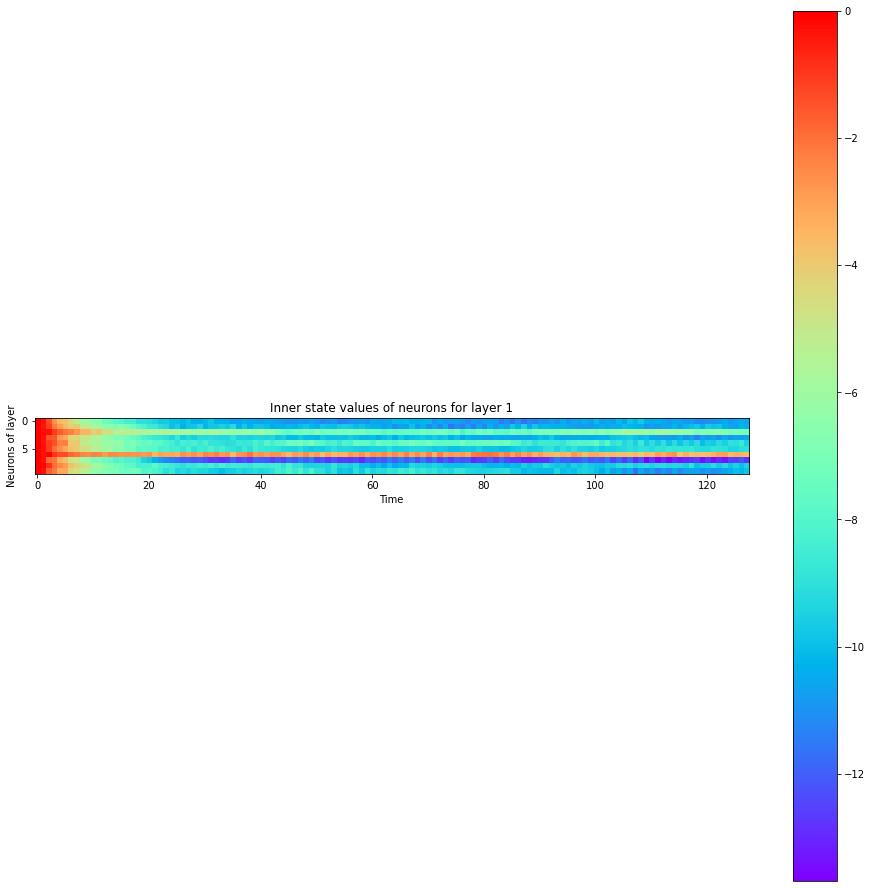

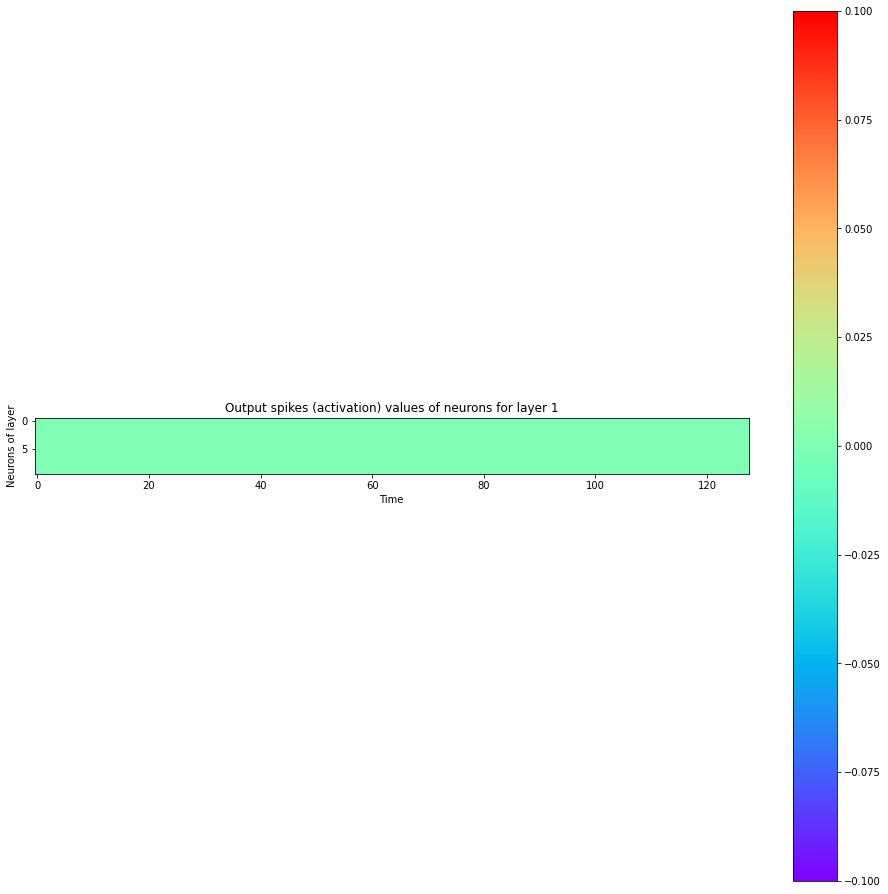

A hidden neuron that looks excited:


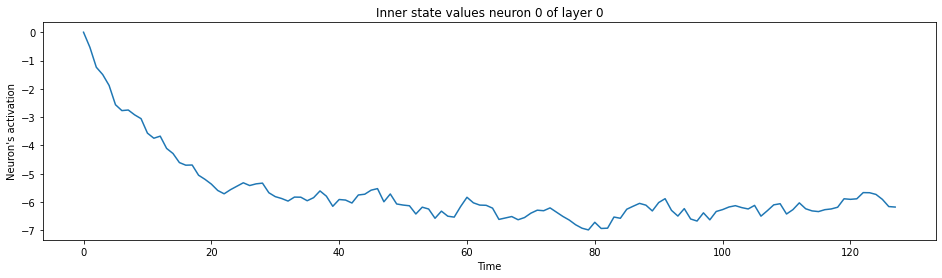

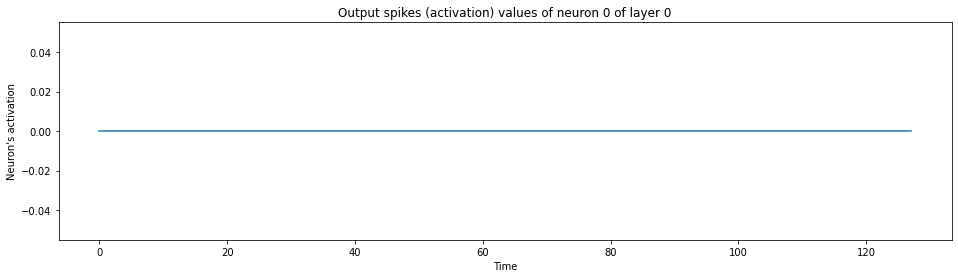

The output neuron of the label:


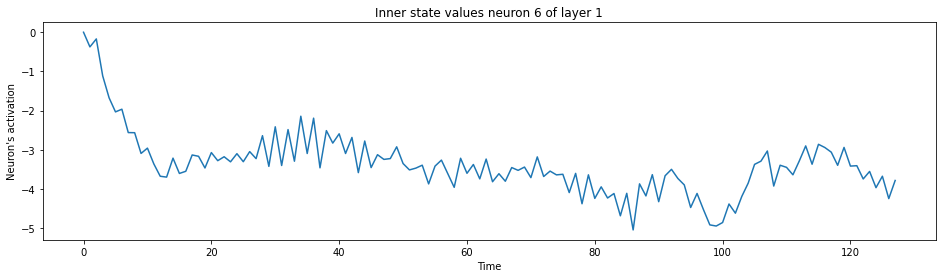

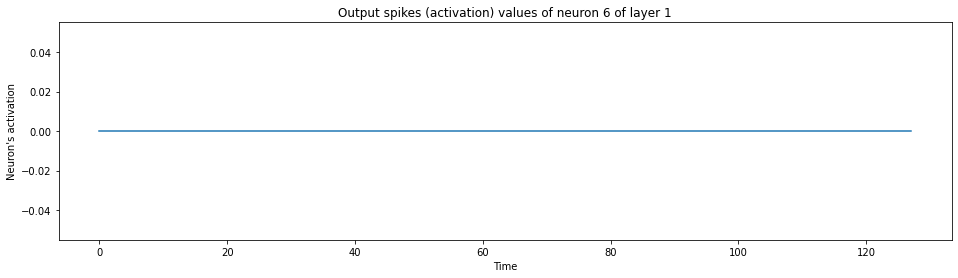

In [70]:
data, target = test_set_loader.__iter__().__next__()
 
# taking 1st testing example:
x = torch.stack([data[100]])
y = target.data.numpy()[100]
plt.figure(figsize=(4,4))
plt.imshow(x.data.cpu().numpy()[0,0])
plt.title("Input image x of label y={}:".format(y))
plt.show()
 
# plotting neuron's activations:
spiking_model.visualize_all_neurons(x)
print("A hidden neuron that looks excited:")
spiking_model.visualize_neuron(x, layer_idx=0, neuron_idx=0)
print("The output neuron of the label:")
spiking_model.visualize_neuron(x, layer_idx=1, neuron_idx=y)
